# Ermine Tutorial 04
## Predict state sequences for single-particle tracking data with ermine

by Sebastian Malkusch (c) 2021  
malkusch@med.uni-frankfurt.de  
Data Science| Klinische Pharmakologie  
Institut für Klinische Pharmakologie  
Goethe - Universität  
Theodor-Stern-Kai 7  
60590 Frankfurt am Main

## Abstarct
In this tutorial, we will label the temporal sequence of molecular jumps by associating each jump with a mobility mode of our hidden Markov model that was parameterized in tutorial 03.

## Prerequisite
* Tutorial 01 must be completed
* The file Fab_CS6_cell20_jumps.csv needs to be saved in folder results
* Tutorial 02 must be completed
* The optimal number of mobility modes must be known
* Tutorial 03 must be completed
* An HMM needs to be parameterized

## Import libraries
You need to install Ermine prior to usage.  
Run  
python -m pip install pyErmine  
from the command line  

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import ermine as em
from matplotlib import pyplot as plt

## Import Jump_df
Store the path to the jump data set in the variable "file_name"
The routine imports the jump data to a data frame (data_df).

In [2]:
file_name = "results/Fab_CS6_cell20_jumps.csv"
data_df = pd.read_csv(filepath_or_buffer = file_name)
data_df.head()

,Unnamed: 0,id_departure,frame_departure,x [nm]_departure,y [nm]_departure,sigma [nm]_departure,intensity [photon]_departure,offset [photon]_departure,bkgstd [photon]_departure,uncertainty_xy [nm]_departure,...,seg.id_destination,seg.loc_count_destination,seg.track_pos_destination,track.noise_destination,track.t_start_destination,track.lifetime_destination,track.id_destination,track.loc_count_destination,track.seg_count_destination,jump_distance
0,0,149,1,31496.6,32117.6,167.4,665.8,34.8,9.3,22.5,...,1.0,9.0,0.0,0.0,1.0,8.0,1.0,9.0,1.0,13.285330
1,1,357,2,31489.3,32106.5,168.6,916.5,33.0,10.8,19.2,...,1.0,9.0,0.0,0.0,1.0,8.0,1.0,9.0,1.0,7.964923
2,2,570,3,31496.3,32110.3,151.3,860.2,38.8,8.0,14.1,...,1.0,9.0,0.0,0.0,1.0,8.0,1.0,9.0,1.0,50.420631
3,3,783,4,31470.3,32067.1,182.5,594.9,32.0,7.3,24.0,...,1.0,9.0,0.0,0.0,1.0,8.0,1.0,9.0,1.0,26.654268
4,4,996,5,31472.0,32093.7,182.9,630.6,31.6,9.5,27.6,...,1.0,9.0,0.0,0.0,1.0,8.0,1.0,9.0,1.0,57.015437


## Define experimental parameters
* Define mobility modes for the model: priorModel_components  
* Define time interval between two measurements : $\tau$  
* Define degrees of freedom for translational movement: dof (tutorial 02)
* define mobility mode weights (tutorial 03)
* define transition probabilities (tutorial 03)
* define expected mean squared displacements (tutorial 03)
* define diffusion coefficients (tutorial 03)

In [3]:
priorModel_components = 3 # estimated in Tutorial 02
tau = 0.02
dof = 4
weights = np.array([0.18397737, 0.28859201, 0.52743061])
transition_probabilities = np.array([[9.57170509e-01, 4.28294557e-02, 3.52491759e-08],
                                     [2.44333751e-02, 9.48943492e-01, 2.66231325e-02],
                                     [4.73471675e-04, 2.08831546e-02, 9.78643374e-01]])
mu = np.array([[ 1369.51580774],
               [ 5198.55501515],
               [14391.12696119]]) 
diffusion_coefficients = np.array([[ 17118.94759672],
                                   [ 64981.93768936],
                                   [179889.08701485]])
print("done")

done


## Create observation sequence
An observation sequence with multiple trajectories is created for training: x_hmm  
The respective trajectory lengths are stored separately: lengths

In [4]:
x_hmm, lengths = em.create_observation_sequence(data_df)
print("done")

done


## Estimate state sequence
The estimation process is done using the Viterbi algorithm. 

In [48]:
hmm = em.ErmineHMM(n_components = priorModel_components,
                   diffusion_degrees_of_freedom = dof,
                   tau = tau,
                   algorithm='viterbi')
    
hmm.startprob_ = weights
hmm.transmat_ = transition_probabilities
hmm.diffusion_coefficients_ = diffusion_coefficients
state_sequence = hmm.predict(x_hmm, lengths)
viterbi_df = pd.DataFrame({"jump": x_hmm[:,0],
                          "state": state_sequence,
                          "D": np.take(diffusion_coefficients, state_sequence)})
viterbi_df.head()

,jump,state,D
0,13.285330,0,17118.947597
1,7.964923,0,17118.947597
2,50.420631,0,17118.947597
3,26.654268,0,17118.947597
4,57.015437,0,17118.947597


## Plot mobility state distribution

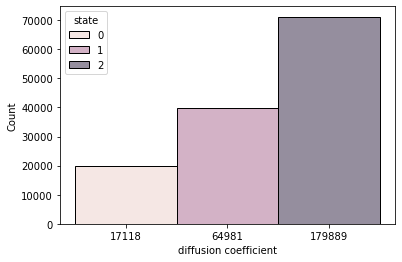

In [52]:
viterbi_df["diffusion coefficient"] = viterbi_df["D"].apply(int).apply(str)
sns.histplot(x="diffusion coefficient",
             hue="state",
             data=viterbi_df
            )
plt.show()